# Label Propagation Modeling

Description: This notebook demonstrates how to implement label propagation for semi-supervised learning using Python.

Prepared by: Kanchana Balasubramanian

About Label Propagation:

*   Predicts neighboring nodes with notion of similarity
*   Suitable for categorical data
**    One-hot encoding
*   Semi-supervised learning
-- Transductive learning – learn unlabeled points from labelled points
-- Training with a mix of labeled and unlabeled dataset



Label propagation is applied on multiple available datasets such as to generate labels for plantation classes - agroforestry, monoculture and not plantation.The label propagation follows a semi-supervised learning approach using logistic regression and deep learning.

# Region: Costa Rica (CR)

	Labelled high confidence training samples generated from the following datasets:
*   CR LULC categories
*   SPDT database
*   Tropical tree cover (TTC)



In [1]:
!pip install geopandas scikit-learn rasterio matplotlib folium gdal
# Install GDAL and other required libraries
#!apt-get install gdal-bin python-gdal python3-gdal

import geopandas as gpd
import numpy as np
from sklearn.semi_supervised import LabelPropagation
from sklearn.preprocessing import LabelEncoder
import rasterio
import random
import pandas as pd
from shapely.geometry import Point, Polygon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 6.5 MB/s eta 0:00:00


Authenticate google drive

In [2]:
from google.colab import drive

# This will prompt you to authorize the Colab notebook to access your Google Drive files.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing labelled data

Polygons are converted to points (centroid) in Arcmap and imported as points dataset. The algorithm can be run with points data.

In [3]:
# Import labelled data shapefile from Google Drive
labelled_data = '/content/drive/MyDrive/WRI_Internship/Plantationclass_highconf_cr/HighConf_Point.shp'
data = gpd.read_file(labelled_data)
data.crs = 'EPSG:5367'

# Print the column names (features/attributes)
print(data.columns)
print(data.dtypes)

Index(['Id', 'gridcode', 'Area', 'LULC', 'MERGE_SRC', 'PClass', 'SDPT',
       'TTC_thres', 'ORIG_FID', 'POINT_X', 'POINT_Y', 'geometry'],
      dtype='object')
Id              int64
gridcode        int64
Area          float64
LULC           object
MERGE_SRC      object
PClass         object
SDPT           object
TTC_thres       int64
ORIG_FID        int64
POINT_X       float64
POINT_Y       float64
geometry     geometry
dtype: object
   Id  gridcode      Area  LULC                         MERGE_SRC  \
0   7         1  23.06800  palm  Palm0_ttc40_hcpoly_5ha_training1   
1  30         1   9.13310  palm  Palm0_ttc40_hcpoly_5ha_training1   
2  33         1  38.25650  palm  Palm0_ttc40_hcpoly_5ha_training1   
3  35         1   1.58103  palm  Palm0_ttc40_hcpoly_5ha_training1   
4  38         1  39.42020  palm  Palm0_ttc40_hcpoly_5ha_training1   

        PClass     SDPT  TTC_thres  ORIG_FID    POINT_X    POINT_Y  \
0  monoculture  oilpalm         40         1 -83.598904  10.540394   
1  mon

Visualize Costarica boundary and high confidence polygons

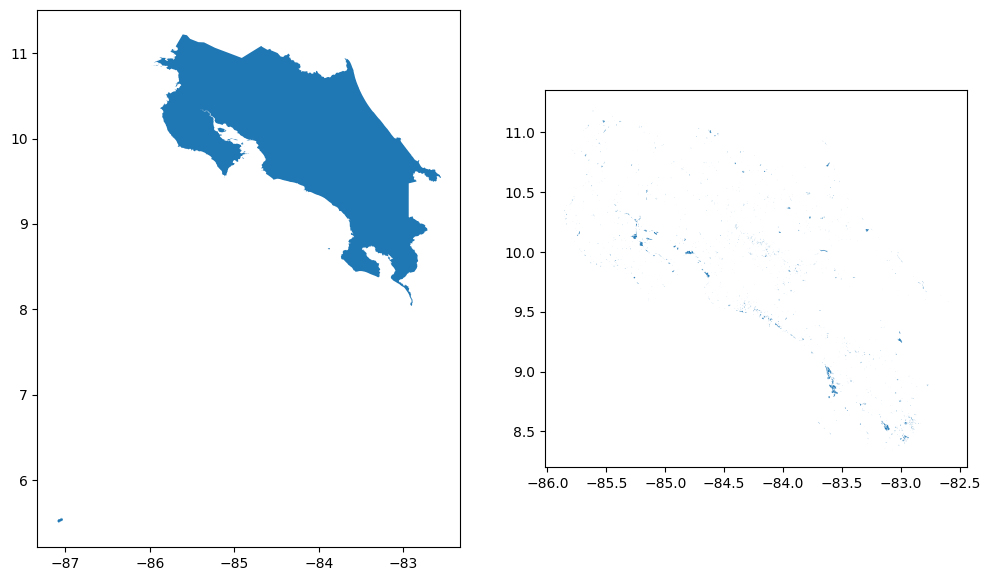

In [4]:
import matplotlib.pyplot as plt

costarica = gpd.read_file('/content/drive/MyDrive/WRI_Internship/Plantationclass_highconf_cr/CRI_boundary/gadm41_CRI_0.shp')
highconf_poly = gpd.read_file('/content/drive/MyDrive/WRI_Internship/Plantationclass_highconf_cr/HighConf_poly1.shp')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,12))
costarica.plot(ax=ax1)
highconf_poly.plot(ax=ax2);

##Function to generate unlabelled points

Unlabelled points are generated using the function here. The points are generated within the Costa Rica boundary map and the points falling within high confidence polygons, which are labelled, are excluded. After exclusion of points not meeting the criteria of falling with the CR bounds and outside the labelled polygons, the function runs back in loop to ensure valid number of points are generated.

In [ ]:
#Function to generate unlabelled points
import numpy as np
from shapely.geometry import Point, Polygon
import pandas as pd
import matplotlib.pyplot as plt

def random_pts_poly(polygon, exclusion_polygon, number):
  valid_points = gpd.GeoDataFrame()

  while len(valid_points) < number:

    # create random points
    minx = polygon.bounds.minx[0]
    miny = polygon.bounds.miny[0]
    maxx = polygon.bounds.maxx[0]
    maxy = polygon.bounds.maxy[0]
    x = np.random.uniform( minx, maxx, number )
    y = np.random.uniform( miny, maxy, number )

    # put in geo dataframe format
    df = pd.DataFrame()
    df['points'] = list(zip(x,y))
    df['points'] = df['points'].apply(Point)
    gdf_points = gpd.GeoDataFrame(df, geometry='points', crs = 'EPSG:5367')

    # only keep those points within polygons
    gdf_points = gdf_points[gdf_points.within(polygon.unary_union)]

    print(f'Total points: {len(gdf_points)}')
    print(gdf_points.head())

    # remove points falling within the high confidence exclusion polygon
    points_to_remove = gdf_points[gdf_points.intersects(exclusion_polygon.unary_union)].index
    gdf_points = gdf_points.drop(points_to_remove)

    valid_points = pd.concat([valid_points, gdf_points], ignore_index=True)

  # Keep only the desired number of points
  valid_points = valid_points[:number]

  print(f'Total points within Costarica and not in high confidence exclusion area: {len(valid_points)}')
  print(gdf_points.head())

  return valid_points

In [ ]:
#Generate unlabelled points
df2 = random_pts_poly(costarica, highconf_poly, 2000)

Total points: 325
                        points
0   POINT (-84.48344 10.80454)
1    POINT (-84.43451 9.79718)
3    POINT (-82.61249 9.58896)
9    POINT (-83.16109 9.07203)
13  POINT (-85.56758 10.75486)
Total points: 304
                        points
3   POINT (-85.19921 10.38880)
37   POINT (-83.88793 9.92680)
41  POINT (-85.64537 11.14801)
54   POINT (-83.78974 9.60804)
61   POINT (-82.93755 9.64365)
Total points: 345
                        points
0   POINT (-83.99188 10.18368)
3    POINT (-82.96063 9.13064)
19  POINT (-85.06152 10.84698)
29  POINT (-84.22318 10.01006)
31   POINT (-83.53585 9.16435)
Total points: 300
                        points
3    POINT (-84.15661 9.59635)
7    POINT (-83.45760 8.52133)
14   POINT (-84.89989 9.82146)
17  POINT (-84.68048 10.52429)
22   POINT (-83.87159 9.66351)
Total points: 348
                        points
9    POINT (-85.19939 9.91715)
18  POINT (-85.31636 10.69216)
19  POINT (-85.61973 11.13891)
21   POINT (-83.37526 9.61312)
34   POINT 

Unlabelled points saved as shapefile so that it doesn't have to be generated repeatedly

In [ ]:
# Save the unlabelled points as a shapefile
output_shapefile = "/content/drive/MyDrive/WRI_Internship/Plantationclass_highconf_cr/output_unlabelledPts.shp"
df2.to_file(output_shapefile)

Import the generated unlabelled points if needed

In [5]:
#Once df2 shape file is saved, it can be read from the file
# To read df2 from the generated shapefile
df2 = gpd.read_file("/content/drive/MyDrive/WRI_Internship/Plantationclass_highconf_cr/output_unlabelledPts.shp")
unlabelled_data = df2

In [6]:
#costarica.plot()

Visualize the generated unlabelled points

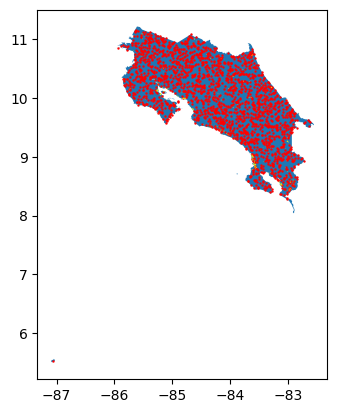

In [7]:
ax = costarica.plot()
df2.plot(ax=ax, color='red', markersize=0.5)
highconf_poly.plot(ax=ax, color='yellow', markersize=0.1);

## Data Preparation

Validate labelled data for any missing values from the plantation class

In [9]:
# Extract the feature columns and the label column from the data
#feature_cols = ['Id', 'POINT_X', 'POINT_Y']
#label_col = 'PClass'

# Check missing values
print(data['PClass'].isnull().sum())

0


## Add attributes (raster values/polygon attributes) to the labelled and unlabelled points from land use/land cover (LULC) raster, TTC raster, and plantation polygon

As a first step, ensuring all datasets are in same projection. EPSG 5327 is used which is a projected CRS. EPSG 5367 is the projection for Costa Rica (Costa Rica Transverse Mercator 2005).

Raster values are extracted using a generated function - extract_raster_values. Raster values from TTC and LULC are extracted to labelled and unlabelled data.

'originalCo' is the attribute from SDPT plantation polygon dataset. This attribute is used since this has three values coded for orchard, forest plantation, and palm. Further, these three categories were used to generate high confidence polygons. So 'originalCo' attribute was good to be used in modeling; hence importing the 'originalCo' attribute to inputs datasets.

In [10]:
#add attributes to the points data from land use/land cover (LULC) raster, TTC raster, and plantation polygon

# TTC data
TTC_raster  = '/content/drive/MyDrive/WRI_Internship/Plantationclass_highconf_cr/TTC/CostaRica_TTC.tif'

# LULC raster file
lulc_raster = '/content/drive/MyDrive/WRI_Internship/Plantationclass_highconf_cr/CR_LULC_EPSG4326WGS1984/LULC_CR_SINIA_EPSG4326.tif'

#SDPT polygon
SDPT_poly_path = '/content/drive/MyDrive/WRI_Internship/Plantationclass_highconf_cr/SDPT_CRI/cri_plant_v2.shp'
SDPT_poly = gpd.read_file(SDPT_poly_path)

#change projection of datasets to EPSG:5367 (projection of LULC layer)
crs_code = '5367' #EPSG
with rasterio.open(TTC_raster, 'r+') as src:
    src.crs = rasterio.crs.CRS.from_epsg(crs_code)
with rasterio.open(lulc_raster, 'r+') as src:
    src.crs = rasterio.crs.CRS.from_epsg(crs_code)
SDPT_poly.crs = crs_code
#unlabelled data
unlabelled_data = df2
# Set the CRS for unlabelled_data
unlabelled_data.crs = 'EPSG:5367'

def extract_raster_values(raster_path, points_gdf, default_value=0):
    with rasterio.open(raster_path) as src:
        values = []
        for point in points_gdf.geometry:
            x, y = point.x, point.y
            row, col = src.index(x, y)

            # Check if the point is within the raster extent
            if 0 <= row < src.height and 0 <= col < src.width:
                value = src.read(1, window=((row, row + 1), (col, col + 1)))
                values.append(value[0][0])
            else:
                values.append(default_value)
    return values

#Add attributes to unlabelled data
#extract values from raster
unlabelled_data['LULC_value'] = extract_raster_values(lulc_raster, unlabelled_data)
unlabelled_data['TTC'] = extract_raster_values(TTC_raster, unlabelled_data)
# Convert 'SDPT_poly' DataFrame to a GeoDataFrame
SDPT_poly = gpd.GeoDataFrame(SDPT_poly)
#Join the points with the SPDT polygon
unlabelled_data = gpd.sjoin(unlabelled_data, SDPT_poly[['originalCo', 'geometry']], how='left', op='within')
output_points_path = '/path/to/your/output_points_unlabelled.shp'
#unlabelled_data.to_file(output_points_path)

#Add attributes to labelled data
#Add TTC for labelled data
data['TTC'] = extract_raster_values(TTC_raster, data)
#add LULC value in labelled data
data['LULC_value'] = extract_raster_values(lulc_raster, data)
#add SDPT 'originalCo' polygon codes in labelled data
#Join the points with the SPDT polygon
data = gpd.sjoin(data, SDPT_poly[['originalCo', 'geometry']], how='left', op='within')

print("Attributes added to points data and saved successfully.")
print("unlabelled_data", unlabelled_data.head())
print("Labelled data", data.head())

Attributes added to points data and saved successfully.
   FID                geometry  LULC_value  TTC  index_right  originalCo
0    0  POINT (-84.483 10.805)           7   40          NaN         NaN
1    1   POINT (-84.435 9.797)           8   90          NaN         NaN
2    2   POINT (-82.612 9.589)           8   90          NaN         NaN
3    3   POINT (-83.161 9.072)           6   60          NaN         NaN
4    4  POINT (-85.568 10.755)           8   90          NaN         NaN


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [11]:
(SDPT_poly.columns)
print(unlabelled_data.head())
print(unlabelled_data['LULC_value'].unique())
print(data['PClass'].unique())

   FID                geometry  LULC_value  TTC  index_right  originalCo
0    0  POINT (-84.483 10.805)           7   40          NaN         NaN
1    1   POINT (-84.435 9.797)           8   90          NaN         NaN
2    2   POINT (-82.612 9.589)           8   90          NaN         NaN
3    3   POINT (-83.161 9.072)           6   60          NaN         NaN
4    4  POINT (-85.568 10.755)           8   90          NaN         NaN
[    7     8     6     3     4    30    17  1040     1    23  1010    21
    10    20     0    22     9    11    14  1210    15    12  1050  1170
  1011    16 65535  1100]
['monoculture' 'agroforestry' 'notplantation']


Check projections of all datasets

In [12]:
#check projection
print(unlabelled_data.crs)
print(SDPT_poly.crs)
with rasterio.open(lulc_raster) as src:
  crs = src.crs
  print(crs)
with rasterio.open(TTC_raster) as src:
  crs = src.crs
  print(crs)

EPSG:5367
EPSG:5367
EPSG:5367
EPSG:5367


Visulize LULC map and the unlabelled points

In [ ]:
#Examine lulc values from the LULC raster
from rasterio.plot import show
import matplotlib.pyplot as plt

lulc_raster = "/content/drive/MyDrive/WRI_Internship/Plantationclass_highconf_cr/CR_LULC_EPSG4326WGS1984/LULC_CR_SINIA_EPSG4326.tif"

#bx = show(rasterio.open(lulc_raster))

#df2.plot(bx=bx, color='red', markersize=0.5)
try:
  with rasterio.open(TTC_raster) as src:
    raster_array = src.read(1)
    transform = src.transform
  fig, ax = plt.subplots(figsize=(8, 8))
  show(raster_array, cmap='viridis', transform=transform, ax=ax)
  unlabelled_data.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=0.5)
  plt.show()
except Exception as e:
    print("An error occurred:", e)

In [13]:
print(np.unique(data['PClass'])) #checking PClass values before encoding it

['agroforestry' 'monoculture' 'notplantation']


## Format and cleanup datasets

- Labelled data: encode plantation class (PClass) values
- Unlabelled data: Add variables - PClass, X and Y

In [14]:
#Format datasets

# Encode categorical PClass to numerical values
label_encoder = LabelEncoder()
y_pseudo_labels_encoded = label_encoder.fit_transform(data['PClass'])
data['PClass'] = y_pseudo_labels_encoded
print("Class labels:", label_encoder.classes_)
print("Encoded pseudo-labels:", label_encoder.transform(label_encoder.classes_))

#Create null predictor 'Pclass' in unlabelled data
unlabelled_data['PClass'] = None
# Extract 'point_x' and 'point_y' coordinates from the 'geometry' column
unlabelled_data['POINT_X'] = unlabelled_data.geometry.x
unlabelled_data['POINT_Y'] = unlabelled_data.geometry.y

#check labelled and unlabelled data and attributes
print(unlabelled_data.head())
print(data.head())

Class labels: ['agroforestry' 'monoculture' 'notplantation']
Encoded pseudo-labels: [0 1 2]


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


Check for null values in the variables that will be used in modeling

In [2]:
#check for Nan values
print('null values in unlabelled:', unlabelled_data.isnull().sum())
print('null values in labelled:', data.isnull().sum())

print(data['PClass'].unique())
print(unlabelled_data['PClass'].unique())

NameError: ignored

Convert null values:
- originalCo values for points that are falling outside the SDPT polygons will have null values. Convert that to zero since the algorithm does not handle null values. For both labelled and unlabelled data.
- The label algorithm will be predicting PClass values of unlabelled data. Those values are null and fill the attribute with '-1', since the algorithm needs the unlabelled data predictor variable to have '-1' values.

In [16]:
#convert Nan values to zero
unlabelled_data['originalCo'] = unlabelled_data['originalCo'].fillna(0)
unlabelled_data['PClass'] = unlabelled_data['PClass'].fillna(-1)
data['originalCo'] = data['originalCo'].fillna(0)

#check again for Nan values
print('null values in unlabelled:', unlabelled_data.isnull().sum())
print('null values in labelled:', data.isnull().sum())

null values in unlabelled: FID               0
geometry          0
LULC_value        0
TTC               0
index_right    1940
originalCo        0
PClass            0
POINT_X           0
POINT_Y           0
dtype: int64
null values in labelled: Id                0
gridcode          0
Area              0
LULC              0
MERGE_SRC         0
PClass            0
SDPT              0
TTC_thres         0
ORIG_FID          0
POINT_X           0
POINT_Y           0
geometry          0
TTC               0
LULC_value        0
index_right    1313
originalCo        0
dtype: int64
   FID                geometry  LULC_value  TTC  index_right  originalCo  \
0    0  POINT (-84.483 10.805)           7   40          NaN         0.0   
1    1   POINT (-84.435 9.797)           8   90          NaN         0.0   
2    2   POINT (-82.612 9.589)           8   90          NaN         0.0   
3    3   POINT (-83.161 9.072)           6   60          NaN         0.0   
4    4  POINT (-85.568 10.755)           8

## Generate Semi-supervised classification dataset
- Semi-supervised classification dataset is a mix of training labelled and unlabelled dataset.
- 'POINT_X', 'POINT_Y', 'LULC_value', 'TTC', 'originalCo' are the dependent variables (X) used to model and 'PClass' is the predictor variable (Y).
- Labelled and unlabelled data are prepared separately for X and Y, before combining them into a mixed training sample.
- Labelled data is then split into training labelled and test labelled dataset.
- Training labelled and unlabelled are combined to generate mixed training sample.
- Test labelled is the hold out dataset to test the accuracy of the model.

In [19]:
#Generate mixed training dataset - labeled + unlabeled
from sklearn.model_selection import train_test_split
import pandas as pd

#Create testing and training data from labelled data
X = data[['POINT_X', 'POINT_Y', 'LULC_value', 'TTC', 'originalCo']]
Y = data['PClass']

#Create X and Y with unlabelled data
X_unlab = unlabelled_data[['POINT_X', 'POINT_Y', 'LULC_value', 'TTC', 'originalCo']]
Y_unlab = unlabelled_data['PClass']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=5, stratify=Y)
X_test_unlab, Y_test_unlab = (X_unlab,Y_unlab)

#Create mixed Training data - labelled data and unlabelled data
test_data = pd.concat([X_test, Y_test], axis=1)
train_data = pd.concat([X_train, Y_train], axis=1)
test_data_unlab = X_test_unlab.copy()
test_data_unlab['PClass'] = Y_test_unlab
mixed_training = pd.concat([train_data, test_data_unlab])

#convert Nan values to zero
#mixed_training['originalCo'] = mixed_training['originalCo'].fillna(0)
#mixed_training['PClass'] = mixed_training['PClass'].fillna(0)

#check for Nan values
print('null values in test_data:', test_data.isnull().sum())
print('null values in train_data:', train_data.isnull().sum())
print('null values in test_data_unlab:', test_data_unlab.isnull().sum())
print('null values in mixed_training:', mixed_training.isnull().sum())

# summarize training set size
print('Labeled Train Set:', X_train.shape, Y_train.shape)
print('Unlabeled Train Set:', X_test_unlab.shape, Y_test_unlab.shape)

# summarize test set size
print('Test Set:', X_test.shape, Y_test.shape)

#shape of mixed training data
print('Mixed training data:', mixed_training.shape)
print(mixed_training.head())

null values in test_data: POINT_X       0
POINT_Y       0
LULC_value    0
TTC           0
originalCo    0
PClass        0
dtype: int64
null values in train_data: POINT_X       0
POINT_Y       0
LULC_value    0
TTC           0
originalCo    0
PClass        0
dtype: int64
null values in test_data_unlab: POINT_X       0
POINT_Y       0
LULC_value    0
TTC           0
originalCo    0
PClass        0
dtype: int64
null values in mixed_training: POINT_X       0
POINT_Y       0
LULC_value    0
TTC           0
originalCo    0
PClass        0
dtype: int64
Labeled Train Set: (1316, 5) (1316,)
Unlabeled Train Set: (2000, 5) (2000,)
Test Set: (878, 5) (878,)
Mixed training data: (3316, 6)
        POINT_X    POINT_Y  LULC_value  TTC  originalCo  PClass
527  -83.431568   9.237953          22    0      7215.0       2
492  -83.666067  10.283372          22    0      7215.0       2
1724 -84.840424   9.974095           9  255         0.0       2
1217 -83.209179   8.772767           7   80         2.0    

## Semi-supervised Label Propagation algorithm
## Model 1: Semi-supervised Label Propagation Model with Logistic Regression Learning
- Inputs to the label propagation algorithm is a mixed training data of labelled and unlabelled dataset that was prepared in previous steps.
-- Input variables: 'POINT_X', 'POINT_Y', 'LULC_value', 'TTC', 'originalCo' are the dependent variables (X) used to model and 'PClass' is the predictor variable (Y).
- Label propagation propagates labels along the neighbourhood and hence using K nearest neighbours would be useful to ensure the predicted label is a representation of a larger polygon. The KNN kernel assigns pseudo-labels to unlabeled data points based on the labels of their K nearest labeled neighbors. In the below code, 14 nearest neighbour pixels will be assessed for generating the predictor labels.
- Label propagation algorithm is first applied on the mixed training dataset. The model performs transductive learning, by learning from the labelled data and predicts the unlabelled PClass.
- Using these generated predictions, which are called trans labels, Model 1 performs a supervised learning using logistic regression, making sure the regression is performed for 3 predictor variables.

In [32]:
#Label propagatin model
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow import keras

# Preprocess the data and extract numerical features
X_train_mixed = mixed_training[['POINT_X', 'POINT_Y', 'LULC_value', 'TTC', 'originalCo']]
y_train_mixed = mixed_training[['PClass']]
y_train_mixed = y_train_mixed.values.ravel() #converting to 1D array

# Encode categorical labels to numerical values
#label_encoder = LabelEncoder()
#y_train_mixed = label_encoder.fit_transform(mixed_training['PClass'])

#print("Class labels:", label_encoder.classes_)
#print("Encoded pseudo-labels:", y_train_mixed)

# Model1: Label propagation model
label_prop_model = LabelPropagation(kernel='knn', n_neighbors=14)

# Fit the model with labeled and unlabeled data
label_prop_model.fit(X_train_mixed, y_train_mixed)
# make predictions on hold out test set
yhat = label_prop_model.predict(X_test)

# calculate score for test set
score = accuracy_score(Y_test, yhat)
print('Accuracy of label prop: %.3f' % (score*100))

# get labels for entire training dataset data
tran_labels = label_prop_model.transduction_

#Model2:supervised learning model with logistic regression
# define supervised learning model
model2 = LogisticRegression(multi_class='ovr', max_iter=2000) #OvR (One-vs-Rest) strategy to handle multi-class classification
# fit supervised learning model on entire training dataset
model2.fit(X_train_mixed, tran_labels)
# make predictions on hold out test set
yhat2 = model2.predict(X_test)
# calculate score for test set
score2 = accuracy_score(Y_test, yhat2)
print('Accuracy of semi-supervised label prop - logreg: %.3f' % (score2*100))

Accuracy of label prop: 99.658
Accuracy of semi-supervised label prop - logreg: 81.435


## Save the predicted labels

In [31]:
from shapely.geometry import Point, Polygon
# Predict labels for the unlabeled data
#y_pred = label_prop_model.transduction_

# Inverse transform numerical labels back to original class labels
y_pred_original_labels = label_encoder.inverse_transform(tran_labels)

# Assign predicted labels to the mixed training dataframe
mixed_training['predicted_labels'] = y_pred_original_labels
geometry = [Point(x, y) for x, y in zip(mixed_training['POINT_X'], mixed_training['POINT_Y'])]
mixed_training_gdf = gpd.GeoDataFrame(mixed_training, geometry = geometry)
#print('mixed_training_gdf', mixed_training_gdf.head)

# Save the results to a shapefile
labelled_shapefile_path = '/content/drive/MyDrive/WRI_Internship/Plantationclass_highconf_cr/output_labelled_shapefile.shp'
mixed_training_gdf.to_file(labelled_shapefile_path, driver='ESRI Shapefile')

<ipython-input-31-0a70f1c18653>:16: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  mixed_training_gdf.to_file(labelled_shapefile_path, driver='ESRI Shapefile')


## Semi-supervised Label Propagation algorithm
## Model 2: Semi-supervised Label Propagation Model with Deep Learning
- Deep learning is used as the supervised learning to assess for improvement in the model performance

In [29]:
#Model3:semi-supervised learning with deep learning
num_classes = len(np.unique(Y_train))
#y_train_one_hot = keras.utils.to_categorical(y_train_mixed, num_classes=num_classes)
#tran_labels_one_hot = keras.utils.to_categorical(tran_labels, num_classes=num_classes)

print('num_classes', num_classes)
#print('tran_labels_one_hot', tran_labels_one_hot)

#Model
model3 = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train_mixed.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax')
])
# Model
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Train the model on the combined labeled and pseudo-labeled data
model3.fit(X_train_mixed, tran_labels, epochs=20, batch_size=16, verbose=1)
# make predictions on hold out test set
yhat3 = model3.predict(X_test)
yhat3_classes = np.argmax(yhat3, axis=1)

# calculate score for test set
score3 = accuracy_score(Y_test, yhat3_classes)
# summarize score
print('Accuracy of semi supervised label prop - deep learning: %.3f' % (score3*100))

num_classes 3
Epoch 1/20
208/208 [==============================] - 1s 2ms/step - loss: 5.7837 - accuracy: 0.6429
Epoch 2/20
208/208 [==============================] - 0s 2ms/step - loss: 2.8315 - accuracy: 0.7639
Epoch 3/20
208/208 [==============================] - 1s 2ms/step - loss: 2.5695 - accuracy: 0.7940
Epoch 4/20
208/208 [==============================] - 1s 3ms/step - loss: 1.8303 - accuracy: 0.8251
Epoch 5/20
208/208 [==============================] - 0s 2ms/step - loss: 1.3306 - accuracy: 0.8607
Epoch 6/20
208/208 [==============================] - 1s 3ms/step - loss: 1.1411 - accuracy: 0.8664
Epoch 7/20
208/208 [==============================] - 1s 3ms/step - loss: 0.7994 - accuracy: 0.8848
Epoch 8/20
208/208 [==============================] - 1s 3ms/step - loss: 0.8246 - accuracy: 0.9065
Epoch 9/20
208/208 [==============================] - 1s 3ms/step - loss: 0.7871 - accuracy: 0.9210
Epoch 10/20
208/208 [==============================] - 1s 3ms/step - loss: 0.8535 - ac

"\n# Predict labels for the unlabeled data\ny_pred = label_prop_model.transduction_\n\n# Inverse transform numerical labels back to original class labels\ny_pred_original_labels = label_encoder.inverse_transform(y_pred)\n\n# Assign the predicted labels to the dataframe\ndata['predicted_labels'] = y_pred_original_labels\n\n# Save the results to a new shapefile or update the existing one\n#output_shapefile_path = '/content/drive/My Drive/path/to/output_shapefile.shp'\ndata.to_file(output_shapefile_path, driver='ESRI Shapefile')\n"